In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data preparation

In [1]:
import pandas as pd

In [2]:
path = '/kaggle/input/mura-data/MURA-v1.1'

#train
train_images = pd.DataFrame(pd.read_csv(path + '/train_image_paths.csv', header = None, names =['image_path']))
train_studies = pd.DataFrame(pd.read_csv(path + '/train_labeled_studies.csv', header= None, names=['study_path', 'label']))

#validation
val_images = pd.DataFrame(pd.read_csv(path + '/valid_image_paths.csv', header = None, names =['image_path']))
val_studies = pd.DataFrame(pd.read_csv(path + '/valid_labeled_studies.csv', header= None, names=['study_path', 'label']))

In [3]:
train_images['study_label'] = train_images['image_path'].str.rsplit('/', n=2, expand=True)[1].str.rsplit('_', n=1, expand=True)[1]

val_images['study_label'] = val_images['image_path'].str.rsplit('/', n=2, expand=True)[1].str.rsplit('_', n=1, expand=True)[1]

In [4]:
train_images['label'] = train_images['study_label'].map({'positive': 1, 'negative': 0})

val_images['label'] = val_images['study_label'].map({'positive': 1, 'negative': 0})

In [5]:
train_images['XR'] = train_images['image_path'].str.rsplit('/', n=5, expand=True)[2]
val_images['XR'] = val_images['image_path'].str.rsplit('/', n=5, expand=True)[2]

# EDA

In [7]:
train_images['label'].value_counts()

label
0    21935
1    14873
Name: count, dtype: int64

In [7]:
# from PIL import Image
# import os
prefix = '/kaggle/input/mura-data/'
# image_paths = train_images['image_path'].tolist() 
# image_sizes = [Image.open(prefix + path).size for path in image_paths] 


In [19]:
# unique_sizes = set(image_sizes)
# if len(unique_sizes) == 1:
#     print("All images are the same size:", unique_sizes.pop())
# else:
#     print(f"Images have different sizes. Unique sizes found: {unique_sizes}")


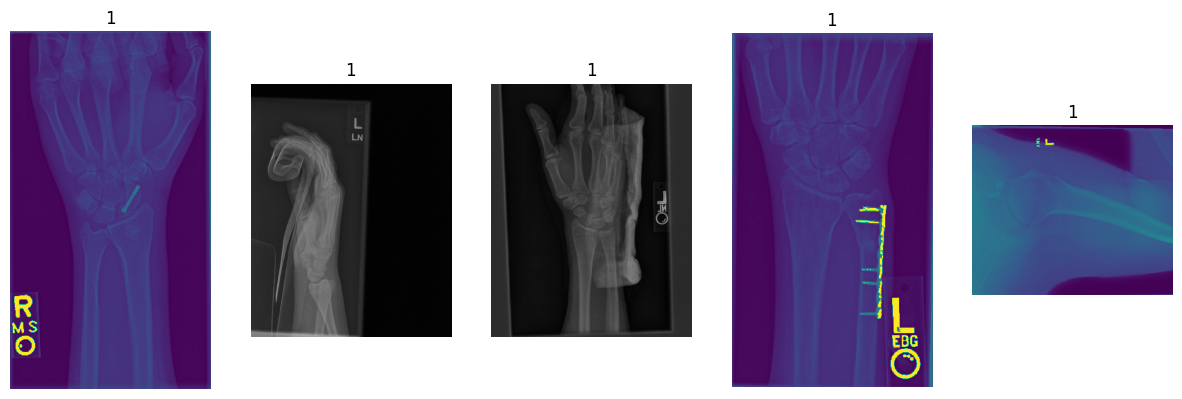

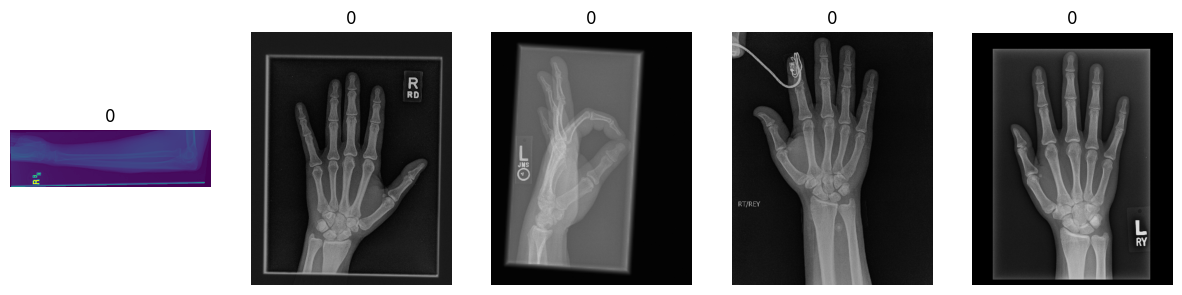

In [8]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def plot_random_images(df, label, n=5):
    images = df[df['label'] == label]['image_path'].sample(n)
    plt.figure(figsize=(15, 15))
    for i, path in enumerate(images):
        img = Image.open(prefix + path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Show samples for each class
for label in train_images['label'].unique():
    plot_random_images(train_images, label)


In [9]:
train_images['XR'].value_counts()

XR
XR_WRIST       9752
XR_SHOULDER    8379
XR_HAND        5543
XR_FINGER      5106
XR_ELBOW       4931
XR_FOREARM     1825
XR_HUMERUS     1272
Name: count, dtype: int64

# Training

In [6]:
prefix = '/kaggle/input/mura-data/'
train_images['image_path'] = prefix + train_images['image_path']

In [7]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (for pre-trained models)
])

# Custom Dataset class to handle loading and transformations
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset and data loader
dataset = ImageDataset(train_images, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch_size as needed


In [8]:
val_images['image_path'] = prefix + val_images['image_path']
val_dataset = ImageDataset(val_images, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)  # Adjust batch_size as needed

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [14]:
num_classes = 2  
model = SimpleCNN(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print loss per epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")
    print("Training complete")

# Start training
#train_model(model, dataloader, criterion, optimizer, num_epochs=10)


In [28]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

# Assuming you have a test or validation DataLoader named `test_dataloader`
#evaluate_model(model, val_dataloader)


In [10]:
def create_dataloader(images:pd.DataFrame, transformer:transforms.Compose, batch_size:int):
    dataset = ImageDataset(images, transform=transformer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [12]:
# An attempt at a unified model, or at least a mixed object model
## note: started having weird issues with Kaggle, so moved testing to my offline copy
class UnifiedCNN(nn.Module):
    def __init__(self):
        super(UnifiedCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch2 = nn.BatchNorm2d(256) # originally had more conv layers after this, runtime bad
        self.fc = nn.Sequential(
            nn.Linear(in_features = 802816, out_features = 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 32, out_features= 1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
num_classes = 2
model = UnifiedCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UnifiedCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=802816, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [11]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
def train_model(model, train_dataloader,val_dataloader, criterion, optimizer, num_epochs=10):
    # Xin's implementation of train_model
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()  # Set the model to training mode
        running_loss = 0.0
        preds, labels = [], []
        for images, label in iter(train_dataloader):
            images, label = images.to(device), label.to(device).float()
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).squeeze(1)
           
            loss = criterion(outputs, label)
            # Accumulate the loss
            running_loss += loss.item()
      

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            probabilities = torch.sigmoid(outputs)
            pred = (probabilities > 0.5).long() 
            preds.append(pred.detach().cpu().numpy())     
            labels.append(label.detach().cpu().numpy())
             
        # train_acc    
        preds = np.hstack(preds)
        labels = np.hstack(labels)
        train_acc.append(accuracy_score(labels, preds))
        
        # train_loss
        loss = running_loss / len(train_dataloader)
        
        train_loss.append(loss)
        
        # Perform validation
        model.eval()
        with torch.no_grad():
            preds, targets = [], []
            running_loss = 0
            for images, label in iter(val_dataloader):
                images, label = images.to(device), label.to(device).float()

                outputs = model(images).squeeze(1)

                loss = criterion(outputs, label)
                running_loss += loss.item()

                # Calculate val_acc
                probabilities = torch.sigmoid(outputs)
                pred = (probabilities > 0.5).long()  # For binary classification
                preds.append(pred.detach().cpu().numpy())
                targets.append(label.detach().cpu().numpy())
        
            preds = np.hstack(preds)
            targets = np.hstack(targets)
        
            val_acc.append(accuracy_score(targets, preds))
            val_loss.append(running_loss / len(val_dataloader))

        spent_time = time.time() - start_time

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}. Spent {spent_time:.4f}s.")
        
    print("Training complete.")
    return train_loss, train_acc, val_loss, val_acc


In [17]:
num_epochs = 10
train_loss, train_acc, val_loss, val_acc = train_model(
    model, dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/10], Training Loss: 0.6746, Validation Loss: 0.7056. Spent 551.1000s.
Epoch [2/10], Training Loss: 0.6747, Validation Loss: 0.7036. Spent 504.0424s.
Epoch [3/10], Training Loss: 0.7145, Validation Loss: 0.7244. Spent 500.3834s.
Epoch [4/10], Training Loss: 0.6747, Validation Loss: 0.8400. Spent 513.9377s.
Epoch [5/10], Training Loss: 0.6747, Validation Loss: 0.7127. Spent 518.5105s.
Epoch [6/10], Training Loss: 0.6747, Validation Loss: 0.7362. Spent 504.9104s.
Epoch [7/10], Training Loss: 0.6747, Validation Loss: 0.7241. Spent 502.6146s.
Epoch [8/10], Training Loss: 0.6746, Validation Loss: 0.7244. Spent 498.6473s.
Epoch [9/10], Training Loss: 0.6747, Validation Loss: 0.7194. Spent 502.6561s.
Epoch [10/10], Training Loss: 0.6747, Validation Loss: 0.7210. Spent 506.5496s.
Training complete.


Text(0.5, 1.0, 'The Loss Curves')

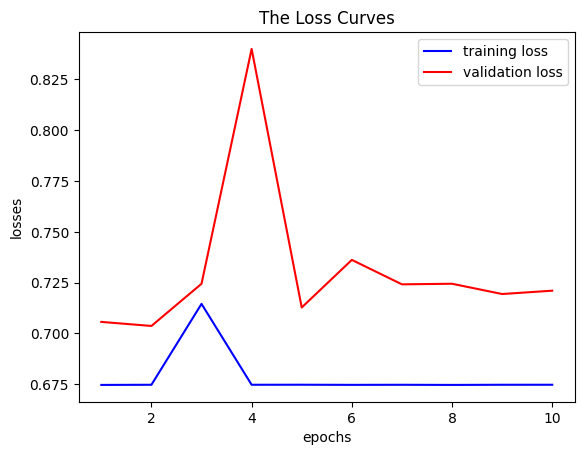

In [19]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, num_epochs + 1), train_loss,'b-', label='training loss')
plt.plot(np.arange(1, num_epochs + 1), val_loss,'r-', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='best')
plt.title('The Loss Curves')

Text(0.5, 1.0, 'The Accuracy Curves')

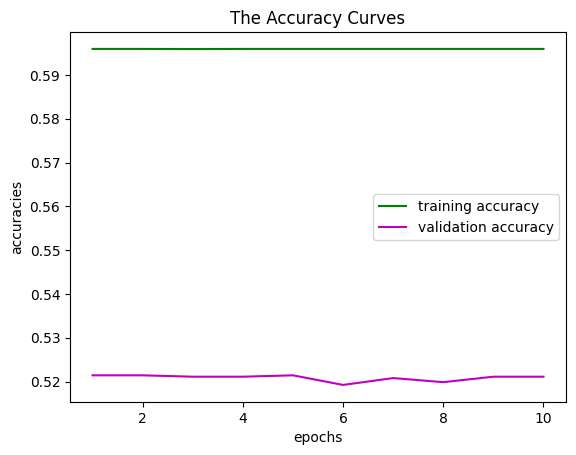

In [20]:
plt.plot(np.arange(1, num_epochs + 1), train_acc,'g-', label='training accuracy')
plt.plot(np.arange(1, num_epochs + 1), val_acc,'m-', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.legend(loc='best')  
plt.title('The Accuracy Curves')

In [12]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [22]:
evaluate_model(model, val_dataloader)

Test Accuracy: 52.11%


In [12]:
# attempt 2 at a unified model
class UnifiedCNN_2(nn.Module):
    def __init__(self):
        super(UnifiedCNN_2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch2 = nn.BatchNorm2d(256) 
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch3 = nn.BatchNorm2d(2048)
        self.fc = nn.Sequential(
            nn.Linear(in_features = 1605632, out_features = 8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 8, out_features= 1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
num_classes = 2
model = UnifiedCNN_2()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UnifiedCNN_2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
   

In [14]:
num_epochs = 10
train_loss, train_acc, val_loss, val_acc = train_model(
    model, dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/10], Training Loss: 0.7945, Validation Loss: 0.7340. Spent 2277.3102s.
Epoch [2/10], Training Loss: 0.7096, Validation Loss: 19.8705. Spent 1735.2012s.
Epoch [3/10], Training Loss: 0.6754, Validation Loss: 2.6074. Spent 1735.8126s.
Epoch [4/10], Training Loss: 0.6751, Validation Loss: 15.4768. Spent 1729.9270s.
Epoch [5/10], Training Loss: 0.6747, Validation Loss: 0.7274. Spent 1728.9223s.
Epoch [6/10], Training Loss: 0.6747, Validation Loss: 0.9682. Spent 1737.8068s.
Epoch [7/10], Training Loss: 0.6747, Validation Loss: 13.2131. Spent 1711.2275s.
Epoch [8/10], Training Loss: 0.6747, Validation Loss: 11.7161. Spent 1709.5575s.
Epoch [9/10], Training Loss: 0.6747, Validation Loss: 13.0023. Spent 1705.1168s.
Epoch [10/10], Training Loss: 0.6747, Validation Loss: 0.7318. Spent 1711.2514s.
Training complete.


In [15]:
evaluate_model(model, val_dataloader)

Test Accuracy: 52.17%


Text(0.5, 1.0, 'The Loss Curves')

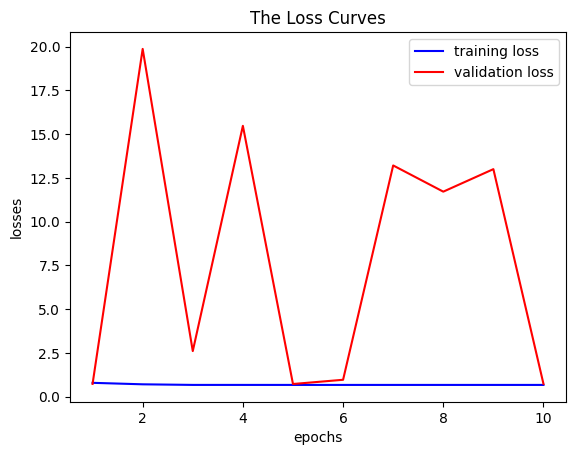

In [16]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, num_epochs + 1), train_loss,'b-', label='training loss')
plt.plot(np.arange(1, num_epochs + 1), val_loss,'r-', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='best')
plt.title('The Loss Curves')

Text(0.5, 1.0, 'The Accuracy Curves')

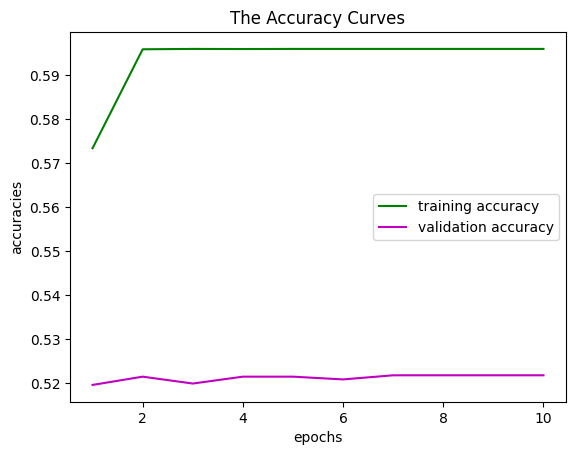

In [17]:
plt.plot(np.arange(1, num_epochs + 1), train_acc,'g-', label='training accuracy')
plt.plot(np.arange(1, num_epochs + 1), val_acc,'m-', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.legend(loc='best')  
plt.title('The Accuracy Curves')

### Specialized Models

In [13]:
from sklearn.model_selection import train_test_split
def subcategorize_data (training:pd.DataFrame, testing:pd.DataFrame, categories:list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    train_img, val_img = train_test_split(training, test_size=0.2)
    train = train_img[train_img['XR'].isin(categories)]
    val = val_img[val_img['XR'].isin(categories)]
    test = testing[testing['XR'].isin(categories)]
    return train, val, test

In [14]:
elbow_train, elbow_val, elbow_test = subcategorize_data(train_images, val_images, ['XR_ELBOW'])
finger_train, finger_val, finger_test = subcategorize_data(train_images, val_images, ['XR_FINGER'])
forearm_train, forearm_val, forearm_test = subcategorize_data(train_images, val_images, ['XR_FOREARM'])
hand_train, hand_val, hand_test = subcategorize_data(train_images, val_images, ['XR_HAND'])
humerus_train, humerus_val, humerus_test = subcategorize_data(train_images, val_images, ['XR_HUMERUS'])
shoulder_train, shoulder_val, shoulder_test = subcategorize_data(train_images, val_images, ['XR_SHOULDER'])
wrist_train, wrist_val, wrist_test = subcategorize_data(train_images, val_images, ['XR_WRIST'])

In [15]:
batch_size = 16
elbow_loader = create_dataloader(elbow_train, transform, batch_size)
elbow_val_loader = create_dataloader(elbow_val, transform, batch_size)
elbow_test_loader = create_dataloader(elbow_test, transform, batch_size)

humerus_loader = create_dataloader(humerus_train, transform, batch_size)
humerus_val_loader = create_dataloader(humerus_val, transform, batch_size)
humerus_test_loader = create_dataloader(humerus_test, transform, batch_size)

finger_loader = create_dataloader(finger_train, transform, batch_size)
finger_val_loader = create_dataloader(finger_val, transform, batch_size)
finger_test_loader = create_dataloader(finger_test, transform, batch_size)

forearm_loader = create_dataloader(forearm_train, transform, batch_size)
forearm_val_loader = create_dataloader(forearm_val, transform, batch_size)
forearm_test_loader = create_dataloader(forearm_test, transform, batch_size)

hand_loader = create_dataloader(hand_train, transform, batch_size)
hand_val_loader = create_dataloader(hand_val, transform, batch_size)
hand_test_loader = create_dataloader(hand_test, transform, batch_size)

shoulder_loader = create_dataloader(shoulder_train, transform, batch_size)
shoulder_val_loader = create_dataloader(shoulder_val, transform, batch_size)
shoulder_test_loader = create_dataloader(shoulder_test, transform, batch_size)

wrist_loader = create_dataloader(wrist_train, transform, batch_size)
wrist_val_loader = create_dataloader(wrist_val, transform, batch_size)
wrist_test_loader = create_dataloader(wrist_test, transform, batch_size)


In [16]:
class Specialized_CNN_3(nn.Module):
    def __init__(self):
        super(Specialized_CNN_3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch2 = nn.BatchNorm2d(256) 
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.batch3 = nn.BatchNorm2d(1024)
        self.fc = nn.Sequential(
            nn.Linear(in_features = 802816, out_features = 8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features = 8, out_features= 1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#### Elbow

In [18]:
elbow_model = Specialized_CNN_3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(elbow_model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
elbow_model.to(device)

Specialized_CNN_3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(

In [19]:
num_epochs = 10
elbow_train_loss, elbow_train_acc, elbow_val_loss, elbow_val_acc = train_model(
    elbow_model, elbow_loader, elbow_val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 2.2876, Validation Loss: 0.6919. Spent 135.6098s.
Epoch [2/10], Training Loss: 0.6870, Validation Loss: 0.6820. Spent 75.8200s.
Epoch [3/10], Training Loss: 0.6809, Validation Loss: 0.6773. Spent 75.9190s.
Epoch [4/10], Training Loss: 0.6784, Validation Loss: 0.6754. Spent 75.5786s.
Epoch [5/10], Training Loss: 0.6769, Validation Loss: 0.6746. Spent 75.2459s.
Epoch [6/10], Training Loss: 0.6768, Validation Loss: 0.6737. Spent 75.3847s.
Epoch [7/10], Training Loss: 0.6764, Validation Loss: 0.6736. Spent 75.5367s.
Epoch [8/10], Training Loss: 0.6764, Validation Loss: 0.6736. Spent 75.2454s.
Epoch [9/10], Training Loss: 0.6765, Validation Loss: 0.6734. Spent 74.7139s.
Epoch [10/10], Training Loss: 0.6761, Validation Loss: 0.6732. Spent 74.9288s.
Training complete.


In [20]:
import matplotlib.pyplot as plt
def loss_curves(train_loss, val_loss):
    plt.plot(np.arange(1, num_epochs + 1), train_loss,'b-', label='training loss')
    plt.plot(np.arange(1, num_epochs + 1), val_loss,'r-', label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.legend(loc='best')
    plt.title('The Loss Curves')
    plt.show()

def accuracy_curves(train_acc, val_acc):
    plt.plot(np.arange(1, num_epochs + 1), train_acc,'g-', label='training accuracy')
    plt.plot(np.arange(1, num_epochs + 1), val_acc,'m-', label='validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracies')
    plt.legend(loc='best')  
    plt.title('The Accuracy Curves')
    plt.show()

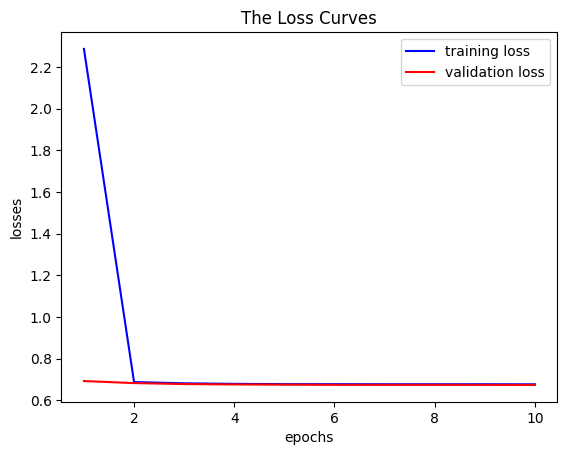

In [21]:
loss_curves(elbow_train_loss, elbow_val_loss)

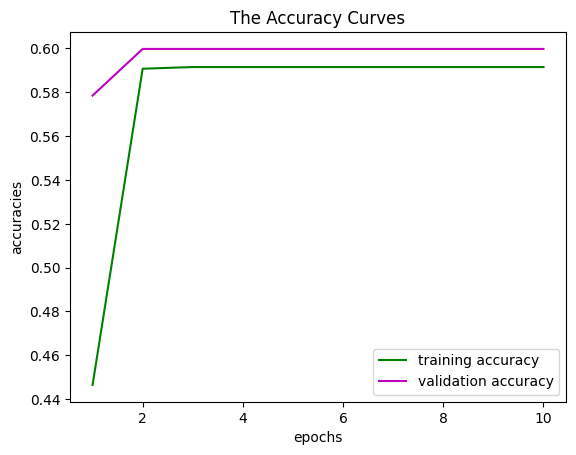

In [22]:
accuracy_curves(elbow_train_acc, elbow_val_acc)

In [23]:
evaluate_model(elbow_model, elbow_test_loader)

Test Accuracy: 50.54%


### Finger

In [39]:
finger_model = Specialized_CNN_3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(finger_model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
finger_model.to(device)

Specialized_CNN_3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(

In [40]:
num_epochs = 10
finger_train_loss, finger_train_acc, finger_val_loss, finger_val_acc = train_model(
    finger_model, finger_loader, finger_val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 3.1392, Validation Loss: 0.6774. Spent 141.2544s.
Epoch [2/10], Training Loss: 0.6831, Validation Loss: 0.7196. Spent 75.6583s.
Epoch [3/10], Training Loss: 0.6966, Validation Loss: 0.6779. Spent 75.6958s.
Epoch [4/10], Training Loss: 1.2971, Validation Loss: 0.6675. Spent 75.3580s.
Epoch [5/10], Training Loss: 0.6961, Validation Loss: 0.6535. Spent 75.6168s.
Epoch [6/10], Training Loss: 0.6717, Validation Loss: 0.6521. Spent 75.0456s.
Epoch [7/10], Training Loss: 0.6717, Validation Loss: 0.6512. Spent 74.8916s.
Epoch [8/10], Training Loss: 0.6701, Validation Loss: 0.6569. Spent 74.6414s.
Epoch [9/10], Training Loss: 0.6716, Validation Loss: 0.6506. Spent 74.5108s.
Epoch [10/10], Training Loss: 0.6700, Validation Loss: 0.6505. Spent 74.1716s.
Training complete.


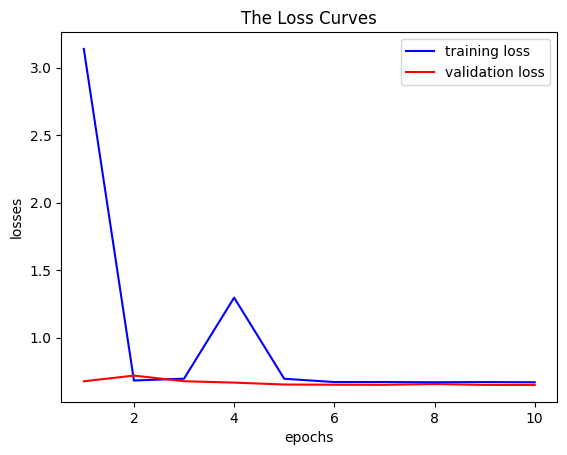

In [41]:
loss_curves(finger_train_loss, finger_val_loss)

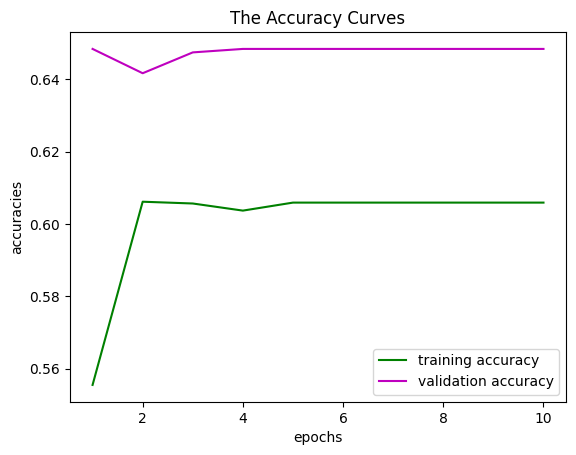

In [42]:
accuracy_curves(finger_train_acc, finger_val_acc)

In [43]:
evaluate_model(finger_model, finger_test_loader)

Test Accuracy: 46.42%


### Forearm

In [44]:
forearm_model = Specialized_CNN_3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(forearm_model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
forearm_model.to(device)

Specialized_CNN_3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(

In [45]:
num_epochs = 10
forearm_train_loss, forearm_train_acc, forearm_val_loss, forearm_val_acc = train_model(
    forearm_model, forearm_loader, forearm_val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 2.3870, Validation Loss: 4.2523. Spent 55.7875s.
Epoch [2/10], Training Loss: 0.7344, Validation Loss: 0.7501. Spent 29.8763s.
Epoch [3/10], Training Loss: 0.7017, Validation Loss: 0.7660. Spent 27.7207s.
Epoch [4/10], Training Loss: 0.6915, Validation Loss: 0.7476. Spent 27.8638s.
Epoch [5/10], Training Loss: 0.7667, Validation Loss: 0.6819. Spent 28.0489s.
Epoch [6/10], Training Loss: 0.6760, Validation Loss: 0.6773. Spent 27.1000s.
Epoch [7/10], Training Loss: 0.6705, Validation Loss: 0.6825. Spent 27.5473s.
Epoch [8/10], Training Loss: 0.6660, Validation Loss: 0.6817. Spent 27.4499s.
Epoch [9/10], Training Loss: 0.6624, Validation Loss: 0.6687. Spent 27.4449s.
Epoch [10/10], Training Loss: 0.6596, Validation Loss: 0.6814. Spent 27.2966s.
Training complete.


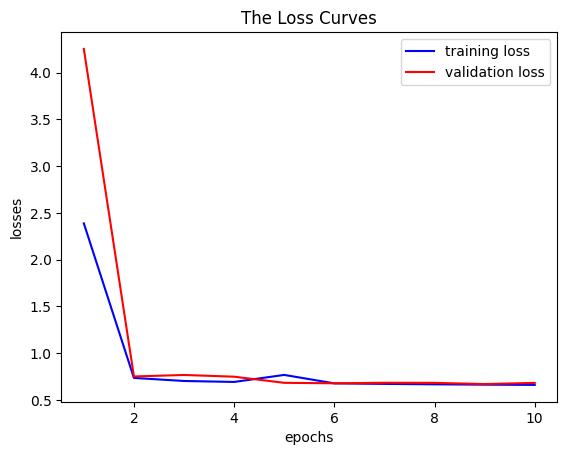

In [46]:
loss_curves(forearm_train_loss, forearm_val_loss)

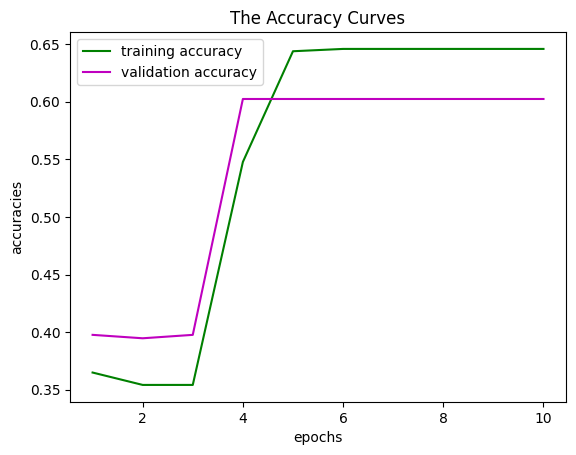

In [47]:
accuracy_curves(forearm_train_acc, forearm_val_acc)

In [48]:
evaluate_model(forearm_model, forearm_test_loader)

Test Accuracy: 49.83%


### Hand

In [24]:
hand_model = Specialized_CNN_3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(hand_model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hand_model.to(device)

Specialized_CNN_3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(

In [25]:
num_epochs = 10
hand_train_loss, hand_train_acc, hand_val_loss, hand_val_acc = train_model(
    hand_model, hand_loader, hand_val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 1.6269, Validation Loss: 0.6333. Spent 163.9117s.
Epoch [2/10], Training Loss: 0.6568, Validation Loss: 0.6110. Spent 85.5522s.
Epoch [3/10], Training Loss: 0.6683, Validation Loss: 0.5970. Spent 85.8127s.
Epoch [4/10], Training Loss: 0.5906, Validation Loss: 0.5893. Spent 85.8417s.
Epoch [5/10], Training Loss: 0.5852, Validation Loss: 0.5863. Spent 84.5739s.
Epoch [6/10], Training Loss: 0.5824, Validation Loss: 0.5856. Spent 85.0883s.
Epoch [7/10], Training Loss: 0.5813, Validation Loss: 0.5860. Spent 84.5234s.
Epoch [8/10], Training Loss: 0.5807, Validation Loss: 0.5843. Spent 84.3360s.
Epoch [9/10], Training Loss: 0.5804, Validation Loss: 0.5827. Spent 84.9528s.
Epoch [10/10], Training Loss: 0.5801, Validation Loss: 0.5832. Spent 84.8408s.
Training complete.


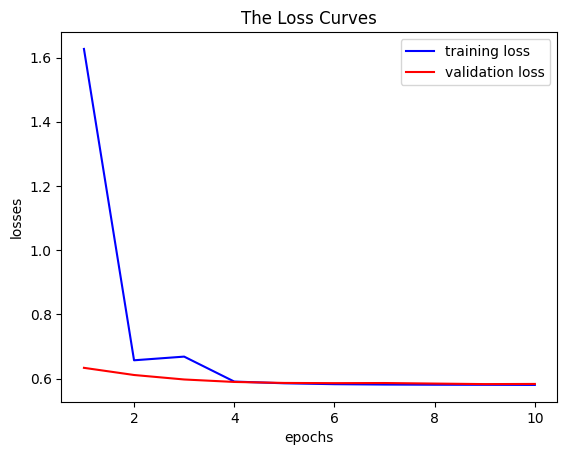

In [26]:
loss_curves(hand_train_loss, hand_val_loss)

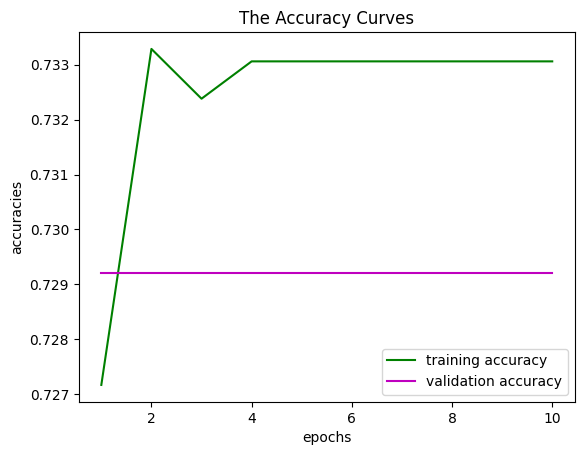

In [27]:
accuracy_curves(hand_train_acc, hand_val_acc)

In [28]:
evaluate_model(hand_model, hand_test_loader)

Test Accuracy: 58.91%


### Humerus

In [29]:
humerus_model = Specialized_CNN_3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(humerus_model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
humerus_model.to(device)

Specialized_CNN_3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(

In [30]:
num_epochs = 10
humerus_train_loss, humerus_train_acc, humerus_val_loss, humerus_val_acc = train_model(
    humerus_model, humerus_loader, humerus_val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 3.1630, Validation Loss: 0.9056. Spent 36.4811s.
Epoch [2/10], Training Loss: 0.6972, Validation Loss: 0.7011. Spent 19.9198s.
Epoch [3/10], Training Loss: 0.7192, Validation Loss: 0.6984. Spent 19.7951s.
Epoch [4/10], Training Loss: 0.6959, Validation Loss: 0.6983. Spent 19.6313s.
Epoch [5/10], Training Loss: 0.6951, Validation Loss: 0.6968. Spent 19.8964s.
Epoch [6/10], Training Loss: 0.6945, Validation Loss: 0.6942. Spent 18.8770s.
Epoch [7/10], Training Loss: 0.6941, Validation Loss: 0.6928. Spent 18.8258s.
Epoch [8/10], Training Loss: 0.6937, Validation Loss: 0.6922. Spent 18.6550s.
Epoch [9/10], Training Loss: 0.6934, Validation Loss: 0.6909. Spent 18.7653s.
Epoch [10/10], Training Loss: 0.6931, Validation Loss: 0.6907. Spent 18.9869s.
Training complete.


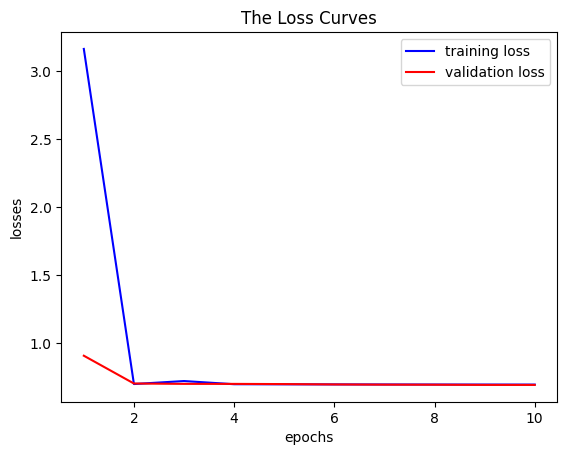

In [31]:
loss_curves(humerus_train_loss, humerus_val_loss)

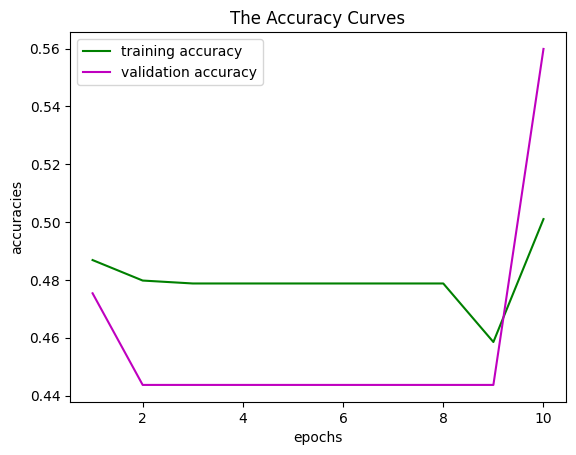

In [32]:
accuracy_curves(humerus_train_acc, humerus_val_acc)

In [33]:
evaluate_model(humerus_model, humerus_test_loader)

Test Accuracy: 51.39%


### Shoulder

In [34]:
shoulder_model = Specialized_CNN_3()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(shoulder_model.parameters(), lr=0.001)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shoulder_model.to(device)

Specialized_CNN_3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(

In [35]:
num_epochs = 10
shoulder_train_loss, shoulder_train_acc, shoulder_val_loss, shoulder_val_acc = train_model(
    shoulder_model, shoulder_loader, shoulder_val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Training Loss: 0.9107, Validation Loss: 0.6934. Spent 239.4627s.
Epoch [2/10], Training Loss: 0.6932, Validation Loss: 0.6932. Spent 129.0859s.
Epoch [3/10], Training Loss: 0.6932, Validation Loss: 0.6932. Spent 129.2568s.
Epoch [4/10], Training Loss: 0.6932, Validation Loss: 0.6932. Spent 129.3061s.
Epoch [5/10], Training Loss: 0.7588, Validation Loss: 0.6931. Spent 129.3621s.
Epoch [6/10], Training Loss: 0.6932, Validation Loss: 0.6931. Spent 129.1699s.
Epoch [7/10], Training Loss: 0.6932, Validation Loss: 0.6931. Spent 129.0978s.
Epoch [8/10], Training Loss: 0.6932, Validation Loss: 0.6931. Spent 128.8126s.
Epoch [9/10], Training Loss: 0.6932, Validation Loss: 0.6931. Spent 128.7241s.
Epoch [10/10], Training Loss: 0.6932, Validation Loss: 0.6932. Spent 129.2475s.
Training complete.


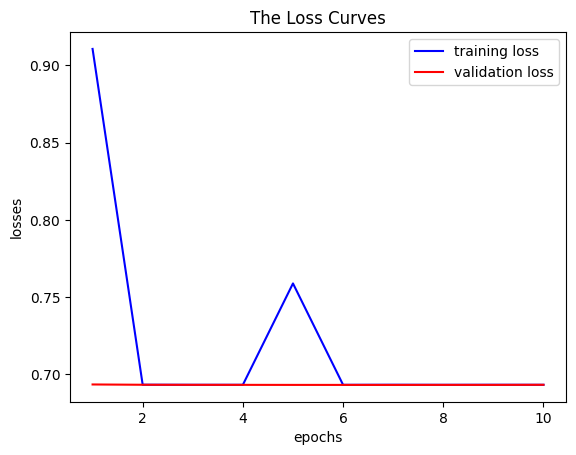

In [36]:
loss_curves(shoulder_train_loss, shoulder_val_loss)

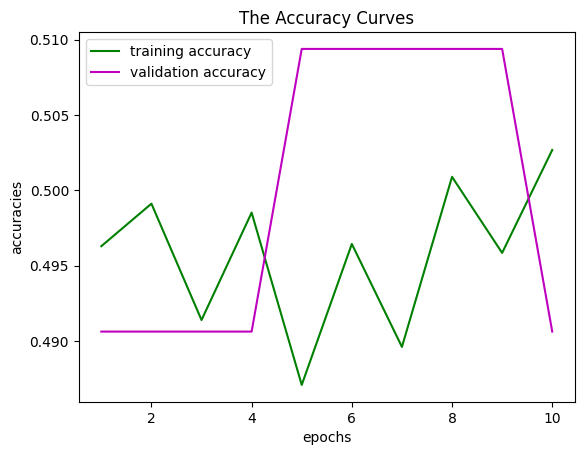

In [37]:
accuracy_curves(shoulder_train_acc, shoulder_val_acc)

In [38]:
evaluate_model(shoulder_model, shoulder_test_loader)

Test Accuracy: 49.38%
